Create a classifier for predicting machine failure. 

### Notes:
* This is a classification problem
* Data source: http://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset# * Steps:    
    1. Download the data
    2. Visualise the data
    3. (If needed) clean, normalise, transform and visualise the data to get a feeling about potential relationships between the variables
        1. You might need to preprocess the output, please check the Attribute information section on the data source page.
    4. Try to find the most relevant features (feature selection)
    5. Try to create new features
    6. Agree on a metric (i.e. Precision and recall)
    7. Develop a classification model (start with simple models and then grow in complexity)    
    8. Analyse the results for train + test data and compare different models

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier

In [53]:
df = pd.read_csv('ai4i2020.csv', sep = ';')
df.shape

(10000, 14)

In [54]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [56]:
df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

<AxesSubplot:xlabel='Type', ylabel='count'>

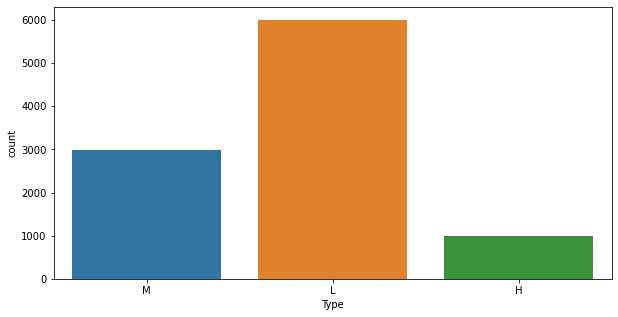

In [57]:
plt.figure(figsize = (10, 5))
sns.countplot(data = df, x = 'Type')

In [58]:
cols_to_drop = ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df.drop(columns = cols_to_drop, axis = 1, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


In [59]:
df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

In [60]:
type1 = pd.get_dummies(df['Type'])

df = pd.concat([df, type1], axis = 1)
df.drop('Type', axis = 1, inplace = True)

df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,H,L,M
0,298.1,308.6,1551,42.8,0,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,0,1,0
2,298.1,308.5,1498,49.4,5,0,0,1,0
3,298.2,308.6,1433,39.5,7,0,0,1,0
4,298.2,308.7,1408,40.0,9,0,0,1,0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  int64  
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  int64  
 5   Machine failure          10000 non-null  int64  
 6   H                        10000 non-null  uint8  
 7   L                        10000 non-null  uint8  
 8   M                        10000 non-null  uint8  
dtypes: float64(3), int64(3), uint8(3)
memory usage: 498.2 KB


In [62]:
x = df.drop(['Machine failure'], axis = 1)
y = df['Machine failure']

print(x.shape, y.shape)

(10000, 8) (10000,)


In [63]:
smote = SMOTE()
x, y = smote.fit_resample(x, y)

print(y.value_counts())

0    9661
1    9661
Name: Machine failure, dtype: int64


In [64]:
def check_skewness(x):
    skew_limit = 0.75
    skew_value = df[x.columns].skew()
    skew_cols = skew_value[abs(skew_value) > skew_limit]
    cols = skew_cols.index
    return cols

skewed_col = check_skewness(x)
print(skewed_col)

pt = PowerTransformer(standardize = False)
x[skewed_col] = pt.fit_transform(x[skewed_col])

Index(['Rotational speed [rpm]', 'H', 'M'], dtype='object')


/Users/crisd/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15457, 8)
(15457,)
(3865, 8)
(3865,)


In [66]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [67]:
def evaluate(model):
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)

    print('model name', model)
    print ('accuracy', accuracy)

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression()
svm = SVC()
dt = DecisionTreeClassifier(max_depth = 6)
rf = RandomForestClassifier(max_samples = 0.9)
knn = KNeighborsClassifier(n_neighbors = 5)

models = [lr, svm, dt, rf, knn]

for model in models:
    evaluate(model)

model name LogisticRegression()
accuracy 0.8561448900388098
model name SVC()
accuracy 0.944372574385511
model name DecisionTreeClassifier(max_depth=6)
accuracy 0.9153945666235447
model name RandomForestClassifier(max_samples=0.9)
accuracy 0.9702457956015524
model name KNeighborsClassifier()
accuracy 0.9606727037516171


In [71]:
base_models = [('RF', RandomForestClassifier(max_samples = 0.9)), ('KNN', KNeighborsClassifier(n_neighbors = 5))]
meta_model = SVC()
stacking_model = StackingClassifier(estimators = base_models, final_estimator = meta_model, passthrough = True, cv = 3)

In [72]:
stacking_model.fit(X_train, y_train)
stacking_model.score(X_test, y_test)

0.9723156532988357

<AxesSubplot:>

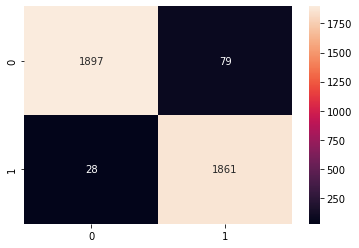

In [75]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = stacking_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = 'g')

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1976
           1       0.96      0.99      0.97      1889

    accuracy                           0.97      3865
   macro avg       0.97      0.97      0.97      3865
weighted avg       0.97      0.97      0.97      3865

